r	N	Error
10	100	2.845e-01
20	400	2.805e-01
40	1600	2.795e-01
80	6400	2.792e-01


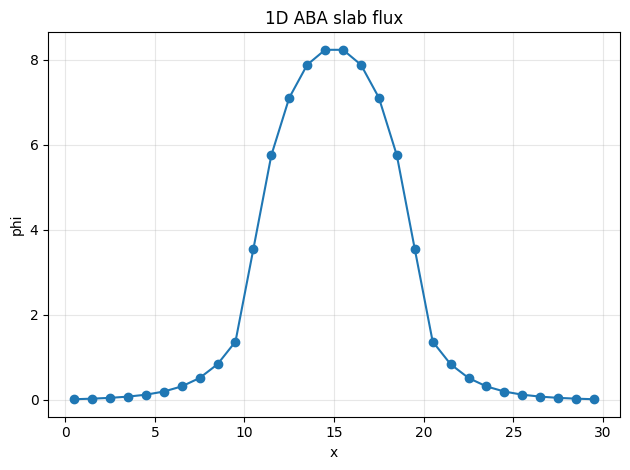

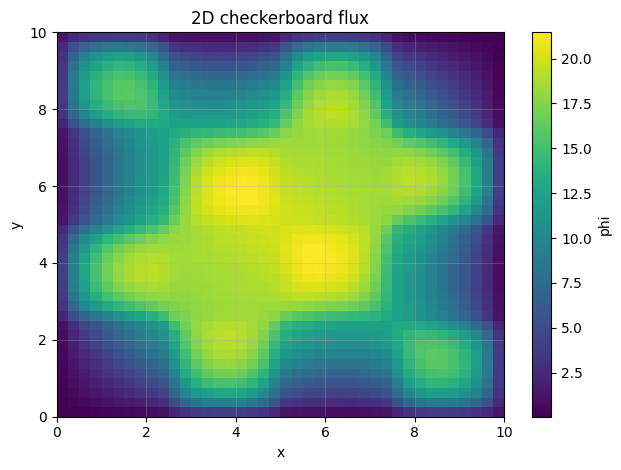

In [2]:
import numpy as np
from mesh import Mesh2D
from materials import MatProps
from solver import DiffusionSolver2D
import matplotlib.pyplot as plt

def l2_error(phi, mesh, phi_exact):
    xc, yc = mesh.xc, mesh.yc
    Nx, Ny = mesh.Nx, mesh.Ny
    diffs = []
    for i in range(Ny):
        for j in range(Nx):
            diffs.append((phi[i,j] - phi_exact(xc[j], yc[i]))**2)
    return np.sqrt(np.mean(diffs))

# MMS constant-coeff
def run_mms(Lx, Ly, D, Sigma_a, refinements):
    errs = []
    for r in refinements:
        mesh = Mesh2D([[1]], (Lx, Ly), r)
        def phi_star(x,y): return np.sin(np.pi*x/Lx)*np.sin(np.pi*y/Ly)
        def Q_func(x,y):
            return (D*(np.pi**2/Lx**2+np.pi**2/Ly**2)+Sigma_a)*phi_star(x,y)
        mats = MatProps(mesh, D={1:D}, Sigma_a={1:Sigma_a}, Q_func=Q_func)
        bcs = dict(left={'type':'dirichlet','value':0}, right={'type':'dirichlet','value':0},
                   bottom={'type':'dirichlet','value':0}, top={'type':'dirichlet','value':0})
        solver = DiffusionSolver2D(mesh, mats, bcs)
        phi,info = solver.solve()
        err = l2_error(phi, mesh, phi_star)
        errs.append(err)
    # print table
    print("r\tN\tError")
    for r,e in zip(refinements,errs):
        N=(r*1)*(r*1)
        print(f"{r}\t{N}\t{e:.3e}")

# 1D ABA slab
def run_1d_aba():
    widths=[12,6,12]
    coarse=[0,1,0]
    mesh=Mesh2D([coarse], (sum(widths),1), 10)
    D={0:2.0,1:0.5}; Sa={0:0.5,1:0.1}; Q={0:0,1:1}
    mats=MatProps(mesh,D=D,Sigma_a=Sa,Q=Q)
    bcs={'left':{'type':'dirichlet','value':0},'right':{'type':'dirichlet','value':0},
         'bottom':{'type':'neumann','value':0},'top':{'type':'neumann','value':0}}
    solver=DiffusionSolver2D(mesh,mats,bcs)
    phi,_=solver.solve()
    solver.plot("1D ABA slab flux")
    plt.xlabel('x'); plt.show()

# 2D checkerboard
def run_checkerboard():
    coarse=[ [1,2,1,2],[2,1,2,1],[1,2,1,2],[2,1,2,1] ]
    mesh=Mesh2D(coarse,(10,10),10)
    D={1:1.0,2:0.2}; Sa={1:0.01,2:0.4}; Q={1:0,2:10}
    mats=MatProps(mesh,D=D,Sigma_a=Sa,Q=Q)
    bcs={'left':{'type':'dirichlet','value':0},'right':{'type':'dirichlet','value':0},
         'bottom':{'type':'dirichlet','value':0},'top':{'type':'dirichlet','value':0}}
    solver=DiffusionSolver2D(mesh,mats,bcs)
    phi,_=solver.solve()
    solver.plot("2D checkerboard flux")
    plt.show()

if __name__=="__main__":
    refinements=[10,20,40,80]
    run_mms(1.0,1.0,1.0,1.0,refinements)
    run_1d_aba()
    run_checkerboard()
